In [1]:
# Install the vncorenlp python wrapper
%pip install vncorenlp
!test -d VnCoreNLP || git clone --depth=1 https://github.com/vncorenlp/VnCoreNLP

# %pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

%pip install umap-learn
%pip install transformers
%pip install gensim
%pip install matplotlib
%pip install wordcloud
%pip install tensorflow
%pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.
'test' is not recognized as an internal or external command,
operable program or batch file.
fatal: destination path 'VnCoreNLP' already exists and is not an empty directory.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\hahuy\code-projects\school\thesis-trend-detection\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch

import gensim
from gensim import corpora

import re, string

from vncorenlp import VnCoreNLP

import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import time
%matplotlib inline

from collections import Counter
from sklearn.metrics import silhouette_score
import umap
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel

rdrsegmenter = VnCoreNLP("VnCoreNLP/VnCoreNLP-1.1.1.jar", annotators="wseg,pos", max_heap_size='-Xmx2g')

In [3]:
torch.cuda.is_available()
torch.cuda.get_device_capability(0)

(6, 1)

In [4]:
ROOT_DIR = "/content/drive/MyDrive/data/"
ROOT_DIR = "../data/"

RAW_DATA_FILE_NAME = "suc-khoe-articles.csv"
CLEANSED_FILE_NAME = "cleansed-tokenized-suc-khoe-articles.csv"

### Load cleansed data from file

In [5]:
processed_data = pd.read_csv(ROOT_DIR + CLEANSED_FILE_NAME)

In [6]:
ind = 12003
print(processed_data['content_lower_case'][ind][:100])
print(processed_data['sentences'][ind][:100])
print(processed_data['token_lists'][ind][:100])
print(processed_data['title'][ind])
processed_data.info()

câu chuyện của chị trần nga, một bệnh nhân, hôm qua 12-10 đi khám chân và được yêu cầu test covid-19
Câu_chuyện của chị Trần_Nga , một bệnh_nhân , hôm_qua 12-10 đi khám chân và được yêu_cầu test COVID-
['câu_chuyện', 'trần_nga', 'bệnh_nhân', 'hôm_qua', 'đi', 'khám', 'chân', 'test', 'giá', 'test', 'sợ'
Lết đi lết lại cái chân đau vì test COVID-19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13411 entries, 0 to 13410
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          13411 non-null  int64 
 1   id                  13411 non-null  int64 
 2   title               13411 non-null  object
 3   date                13411 non-null  object
 4   source              13411 non-null  object
 5   category            13411 non-null  object
 6   content_lower_case  13399 non-null  object
 7   sentences           13399 non-null  object
 8   token_lists         13411 non-null  object
dtypes: int64(2)

#### Utils

In [7]:
def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:15])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()


def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6), dpi=80)

    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)

def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    
def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    print('Getting wordcloud for topic {} ...'.format(topic))
    tokens = []
    if model.method == 'LDA':
        # for t in range(model.ldamodel.num_topics):
        tokens = " ".join([x[0] for x in tm.ldamodel.show_topic(topic,topn=200)])
    else:
      lbs = model.cluster_model.labels_
      tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800*2, height=560*2,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8 * 2, 5.6 * 2), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    print('Getting wordcloud for topic {}. Done!'.format(topic))

In [8]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//200 >0:
    n = len(text1.split())//200
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:250]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*200:w*200 + 250]
      l_total.append(" ".join(l_parcial))
  return l_total

In [9]:
import logging as log

log.basicConfig(level=log.ERROR)
log.getLogger('numba').setLevel(log.ERROR)
log.getLogger('urllib3').setLevel(log.ERROR)

### Model

In [10]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

class Autoencoder(tf.keras.Model):
    
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """
    # dim thogn thuong la 32
    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
import pickle
# from Autoencoder import *
#from preprocess import *
from datetime import datetime
import tensorflow as tf

# define model object
class Topic_Model(tf.keras.Model):
    def __init__(self, k=10, method='TFIDF',gamma=15, vec1 = None, vec2 = None):
        super(Topic_Model, self).__init__()
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT', 'PHOBERT', 'LDA_PHOBERT', 'BERT_LONG', 'PHOBERT_LONG' ,'LDA_BERT_LONG', 'LDA_PHOBERT_LONG', 'CUSTOM_VEC', 'CUSTOM_VEC_1'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = gamma  # parameter for relative importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        self.super_vec = 0
        self.vec1 , self.vec2 = vec1, vec2
        

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vector representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            pickle.dump(vec, open(''+ self.id + '_vec_lda.pkl', 'wb'))
            return vec

        elif method == 'BERT':
            """
                Get the BERT vector representation (document embedding for all documents)
                The lenght of document is 256 token. It can contain all semantic of document.
                :return: vec_bert
            """
            import torch
            from transformers import AutoModel, AutoTokenizer

            tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
            model = AutoModel.from_pretrained("bert-base-multilingual-cased",  output_hidden_states=True)

            L_input = []
            L_result = []

            num_split = 100

            for i in range(len(sentences)//num_split + 1):
              if i*num_split > len(sentences):
                L_input.append(sentences[i*num_split:])
                break
              elif i*num_split == len(sentences):
                break
              else:
                L_input.append(sentences[i*num_split: (i+1)*num_split])
            
            print(str(len(L_input)) + " - concate " + str(num_split) + " for 1 of the inputs")

            for idx, inputs in enumerate(L_input):
              print("Progress: " + str(idx/len(L_input) * 100) + " % completed" )

              encoded_input = tokenizer(inputs, padding=True, truncation=True, max_length=512, return_tensors='pt')


              #Compute token embeddings
              with torch.no_grad():
                  model_output = model(**encoded_input)
                  sentence_embeddings = model_output[0][:,0] #Take the first token ([CLS]) from each sentence
                  #sentence_embeddings1 = sentence_embeddings
                  L_result.append(sentence_embeddings)
            vec = np.concatenate(L_result, axis=0)
            pickle.dump(vec, open(''+ self.id + '_512_' + str(len(sentences))+'_vec_bert.pkl', 'wb'))
            return vec
        
        elif method == 'PHOBERT_LONG':
          import torch
          from transformers import AutoModel, AutoTokenizer

          d0 = torch.device("cuda:0")

          tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
          model = AutoModel.from_pretrained("vinai/phobert-base",  output_hidden_states=True)
          model = model.to(d0)
          sentences1 = sentences

          L_input = []
          L_result = []

          num_split = 100

          for i in range(len(sentences1)//num_split + 1):
            if i*num_split > len(sentences1):
              L_input.append(sentences1[i*num_split:])
              break
            elif i*num_split == len(sentences1):
              break
            else:
              L_input.append(sentences1[i*num_split: (i+1)*num_split])

          print(str(len(L_input)) + " - concate " + str(num_split) + " for 1 of the inputs")

          for idx, inputs in enumerate(L_input):
            sentences_list = [get_split(input) for input in inputs]
            sentences_list_index = [len(stc) for stc in sentences_list]
            
            encoded_input = tokenizer(sum(sentences_list, []), padding=True, truncation=True, max_length=256, return_tensors='pt')

            for x in encoded_input:
              encoded_input[x] = encoded_input[x].to(d0)

            #Compute token embeddings
            with torch.no_grad():
                model_output = model(**encoded_input)
                sentence_embeddings = model_output[0][:,0] #Take the first token ([CLS]) from each sentence 
                print(sentence_embeddings.size())
                # print(type(sentence_embeddings))
                # print(sentence_embeddings.size())
                for stc_len in range(len(sentences_list_index)):
                  first_index = sum(sentences_list_index[:stc_len])
                  cat_sentence_embedding = torch.mean(sentence_embeddings[first_index: first_index + sentences_list_index[stc_len]], dim=0)
                  L_result.append(cat_sentence_embedding.tolist())
            print("Progress: " + str(idx/len(L_input)) + " % completed" )
          vec = np.array(L_result)
          pickle.dump(vec, open(''+ self.id + '_512_' + str(len(sentences))+'_vec_bert.pkl', 'wb'))
          return vec

        elif method == 'LDA_PHOBERT_LONG':
        #else:
            vec_lda = self.vec["LDA"] if "LDA" in self.vec else \
                        self.vectorize(sentences, token_lists, method='LDA')

            vec_bert = self.vec["PHOBERT_LONG"] if "PHOBERT_LONG" in self.vec  else \
                self.vectorize(sentences, token_lists, method='PHOBERT_LONG')

            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]

            self.vec['LDA_PHOBERT_LONG'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec


    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]


        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
                def get_vec_lda(model, corpus, k):
                  """
                  Get the LDA vector representation (probabilistic topic assignments for all documents)
                  :return: vec_lda with dimension: (n_doc * n_topic)
                  """
                  n_doc = len(corpus)
                  vec_lda = np.zeros((n_doc, k))
                  for i in range(n_doc):
                      # get the distribution for the i-th document in corpus
                      for topic, prob in model.get_document_topics(corpus[i]):
                          vec_lda[i, topic] = prob

                  return vec_lda

                vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
                print('Getting vector representations for LDA. Done!')
                pickle.dump(vec, open(''+ self.id + '_vec_lda.pkl', 'wb'))
        else:
            self.cluster_model = m_clustering(self.k)
            print('Vectorizing articles...')
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            print('Clustering...')
            self.cluster_model.fit(self.vec[method])
            print('Clustering done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

### LDA + PhoBERT

In [12]:
# Pho BERT  with 256 tokens for sentence

df_tset_sample = processed_data[-100:]
df_tset_sample = df_tset_sample.dropna()
df_tset_sample.info()

sentences = df_tset_sample["sentences"].to_list()
sentences1 = df_tset_sample["content_lower_case"].to_list()
token_lists = df_tset_sample["token_lists"].to_list()

import ast
token_lists = [ast.literal_eval(x) for x in token_lists]

tm = Topic_Model(method = 'LDA_PHOBERT_LONG', k=10)

with open("LDA_PHOBERT_LONG_2022_03_01_12_42_54_vec_lda.pkl", "rb") as file:
  vec_lda = pickle.load(file)
tm.vec["LDA"] = vec_lda

tm.fit(sentences1, token_lists)

print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
print('Silhouette Score:', get_silhouette(tm))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 13311 to 13410
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          100 non-null    int64 
 1   id                  100 non-null    int64 
 2   title               100 non-null    object
 3   date                100 non-null    object
 4   source              100 non-null    object
 5   category            100 non-null    object
 6   content_lower_case  100 non-null    object
 7   sentences           100 non-null    object
 8   token_lists         100 non-null    object
dtypes: int64(2), object(7)
memory usage: 7.8+ KB
Vectorizing articles...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1 - concate 100 for 1 of the inputs


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

Calculating UMAP projection ...
Calculating UMAP projection. Done!
Getting wordcloud for topic 0 ...
Getting wordcloud for topic 0. Done!
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 1. Done!
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 2. Done!
Getting wordcloud for topic 3 ...
Getting wordcloud for topic 3. Done!


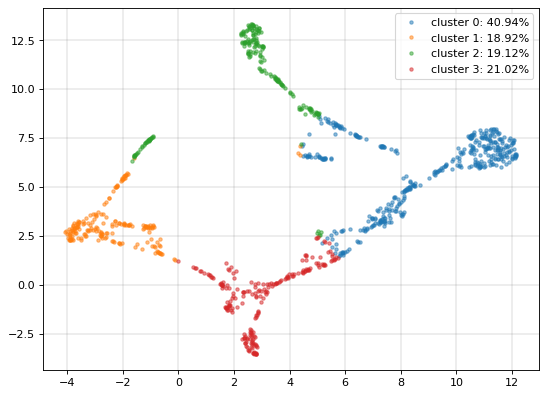

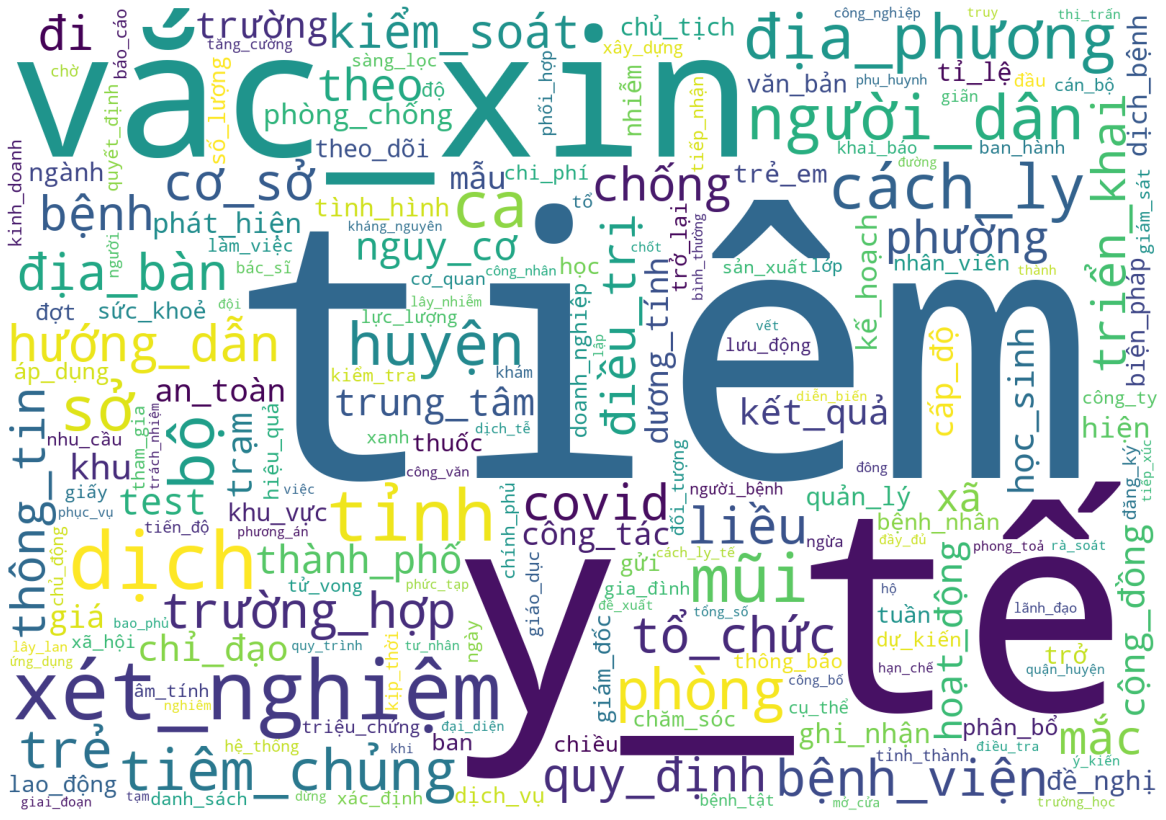

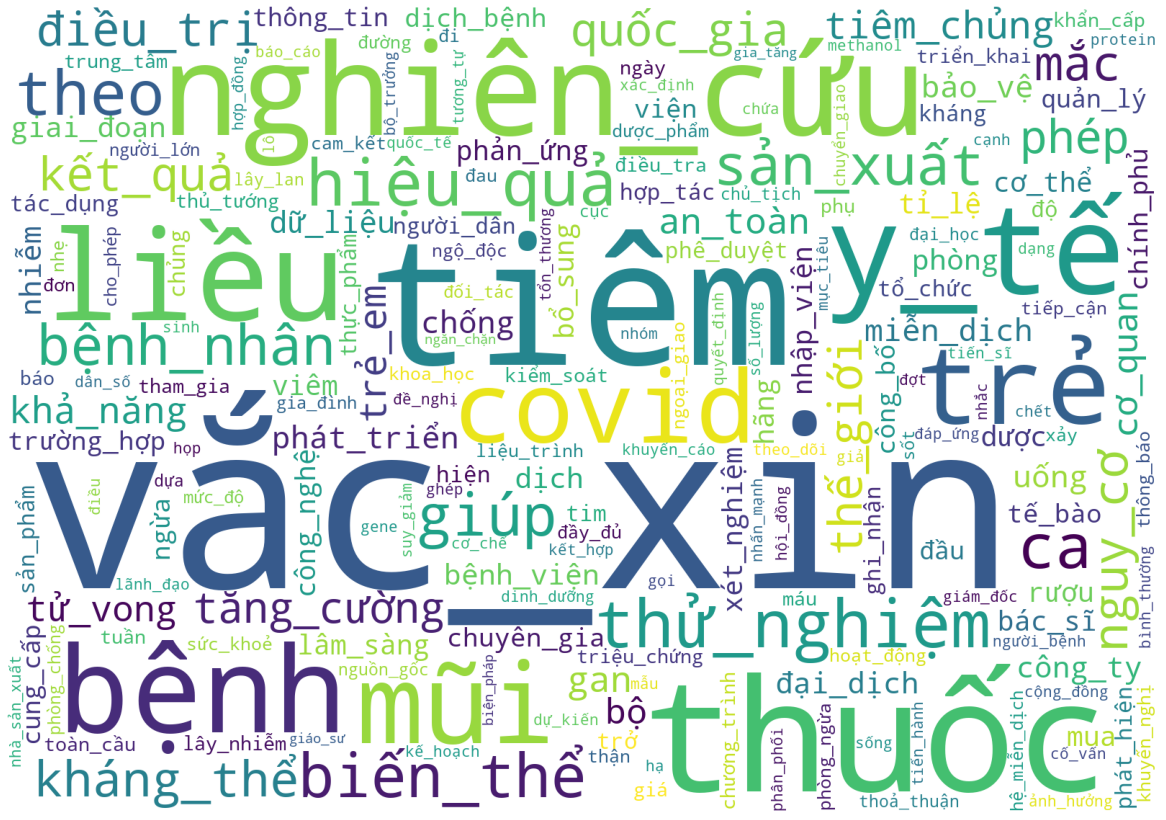

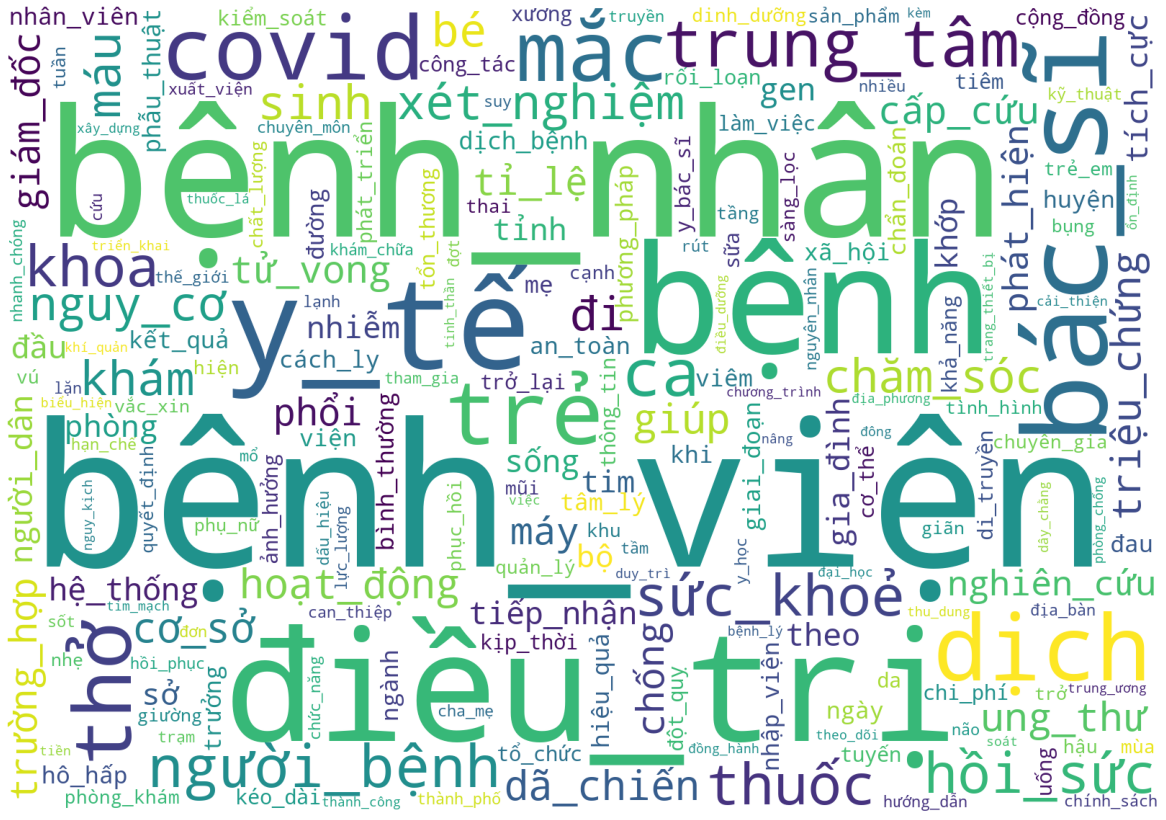

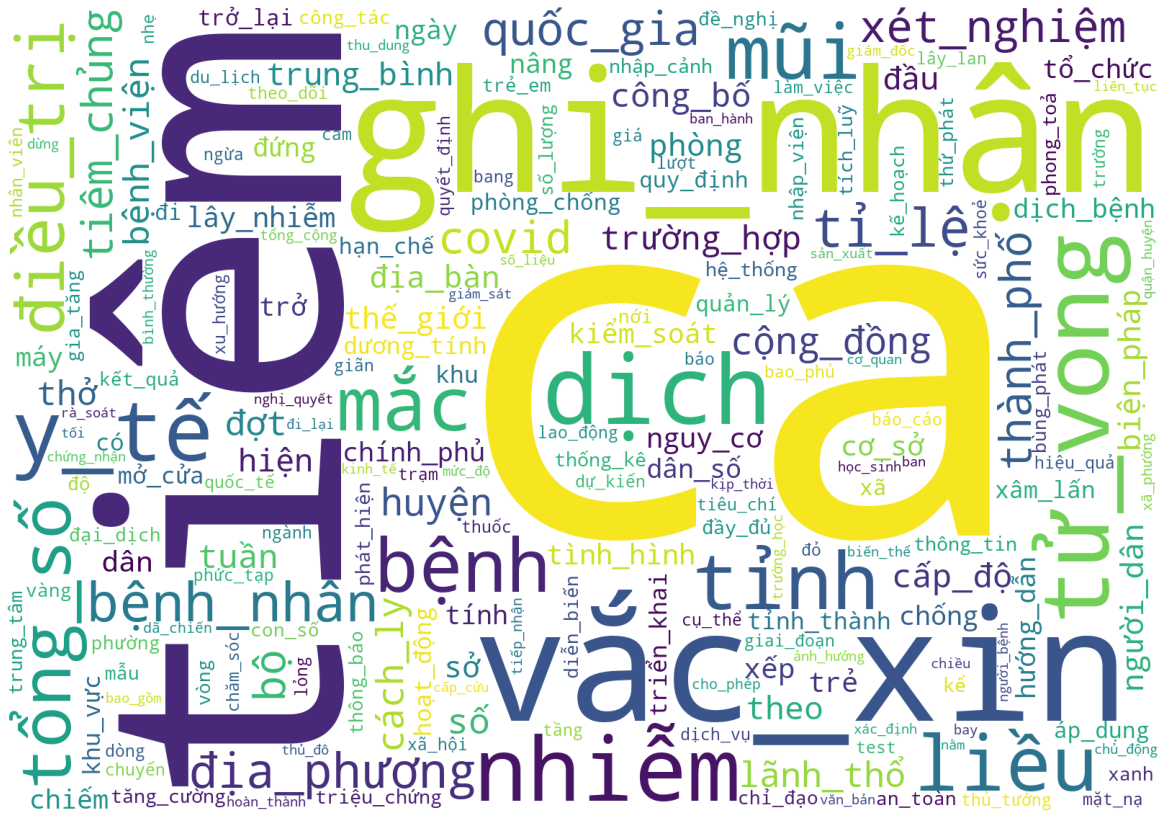

In [ ]:
visualize(tm)
for i in range(tm.k):
    get_wordcloud(tm, token_lists, i)

In [ ]:
from gensim.models import TfidfModel

dct = tm.dictionary
corpus = [dct.doc2bow(line) for line in token_lists]
tfidf_model = TfidfModel(corpus)

Getting wordcloud for topic 0 ...
Getting wordcloud for topic 1 ...
Getting wordcloud for topic 2 ...
Getting wordcloud for topic 3 ...


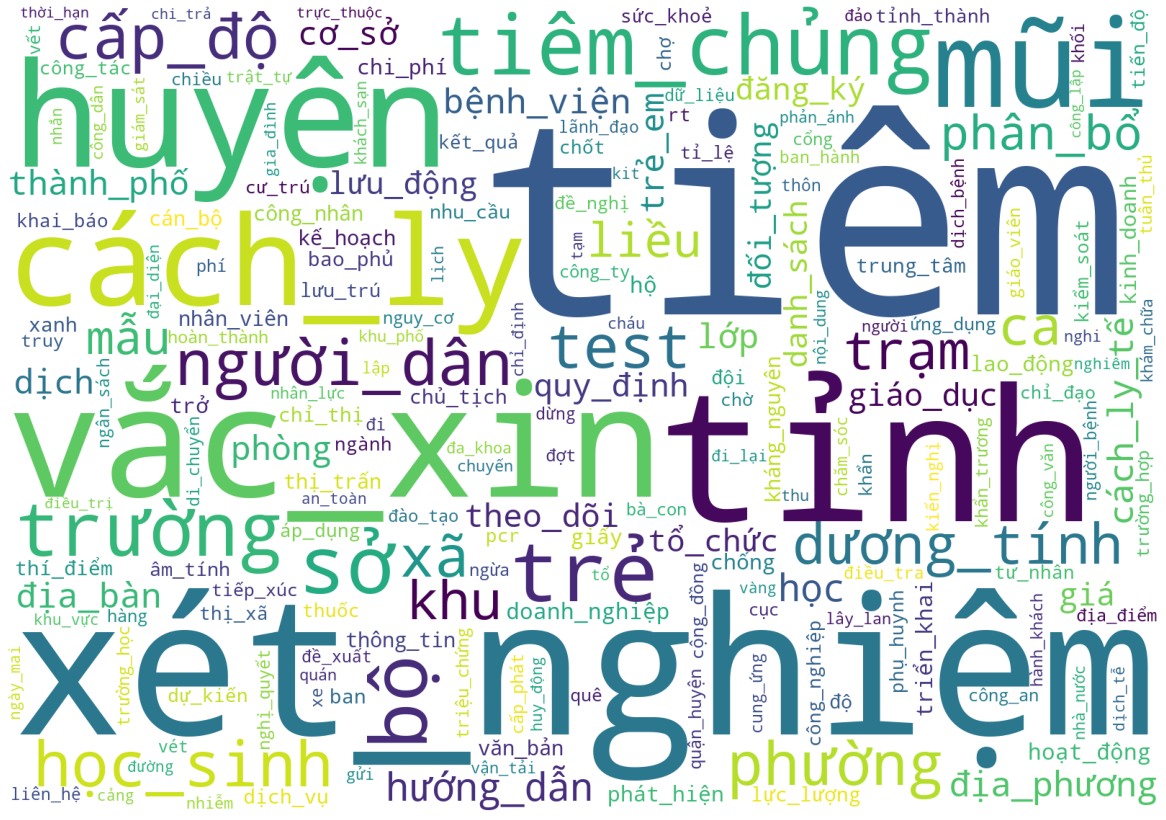

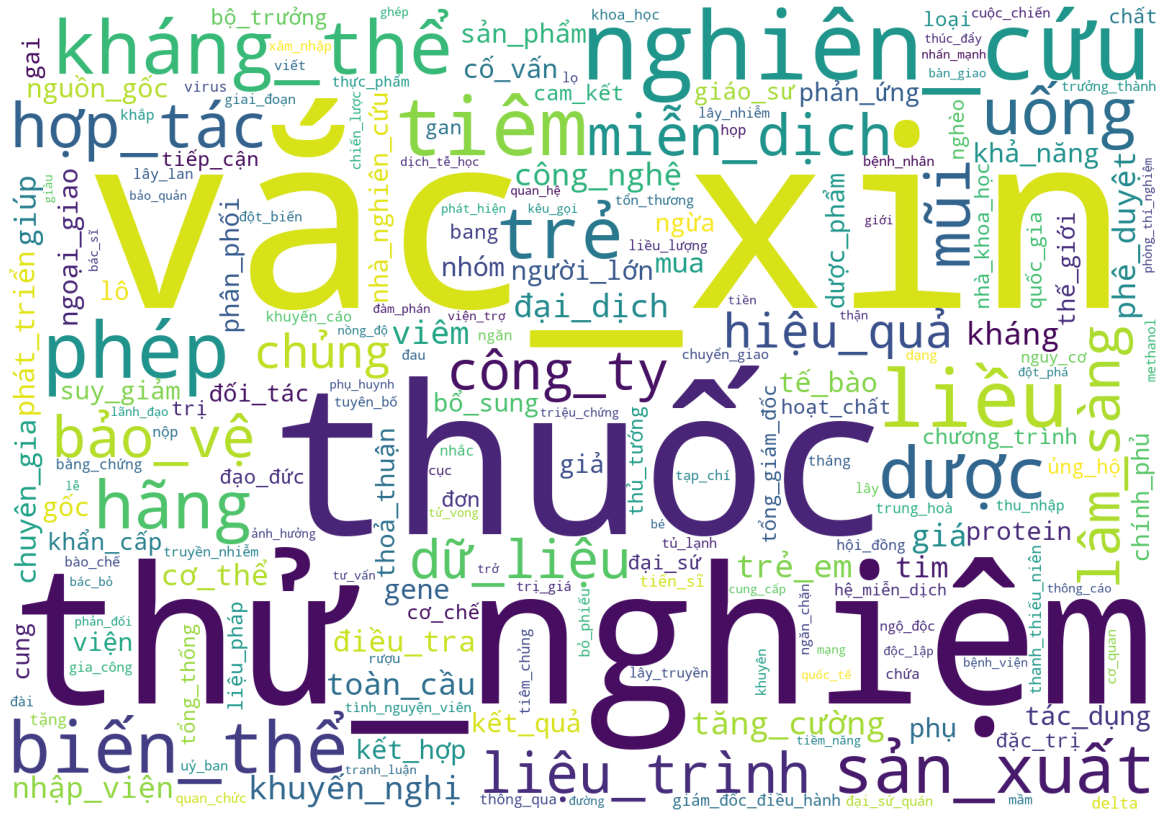

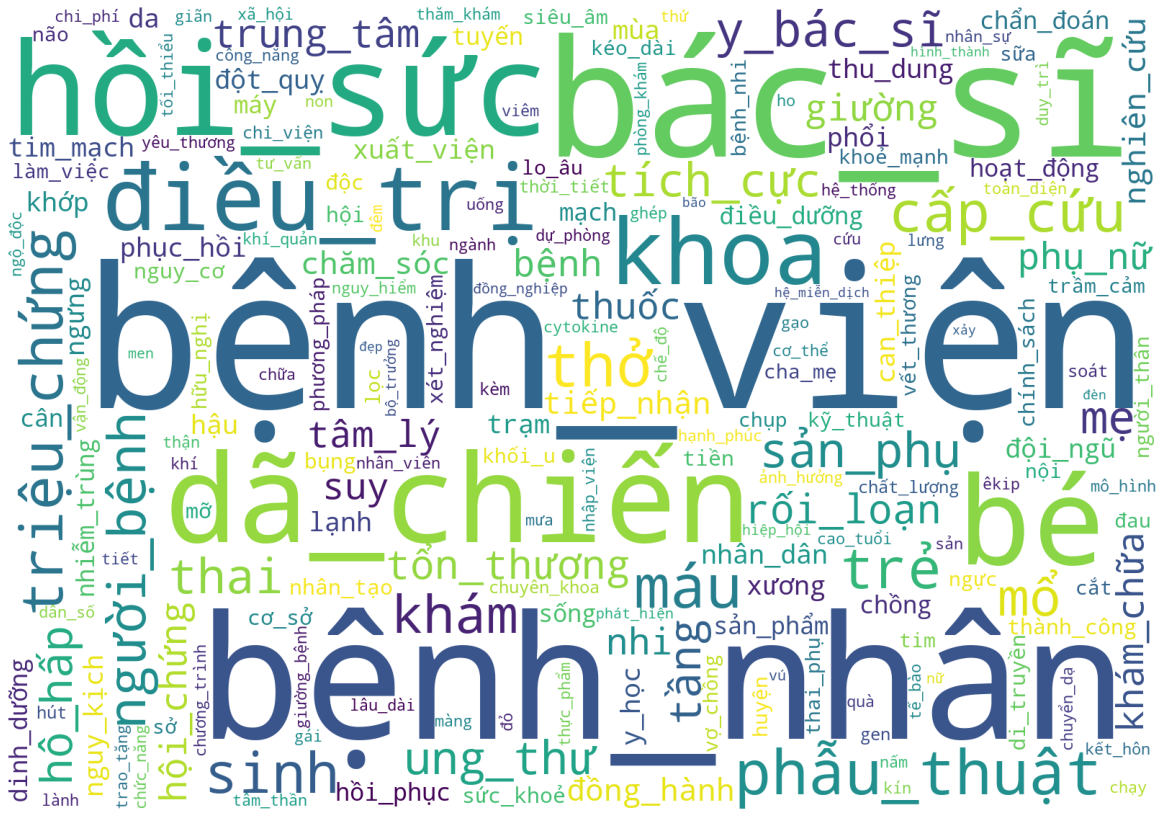

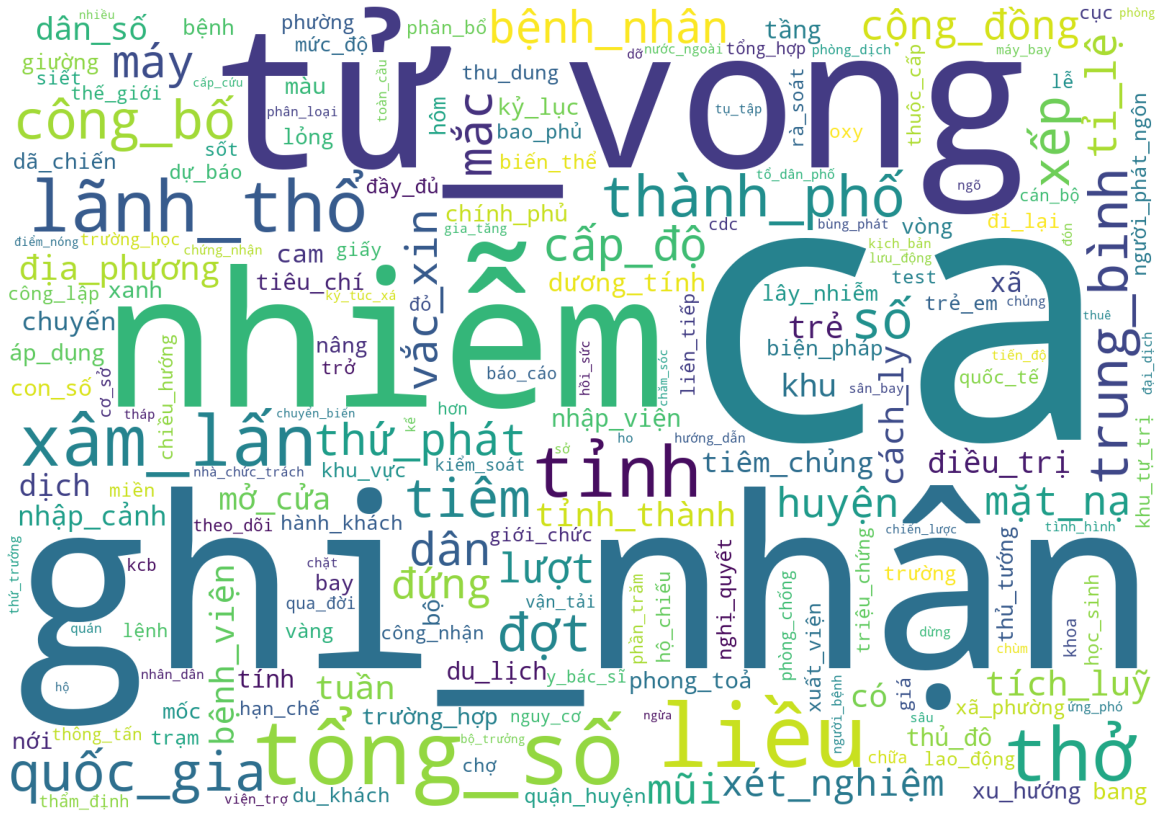

In [ ]:
def get_wordcloud_tfidf(model, token_lists, topic):
    WORD_PER_DOC = 20
    print('Getting wordcloud for topic {} ...'.format(topic))
    tokens = []
    lbs = model.cluster_model.labels_
    docs = [x for x in np.array(corpus)[lbs == topic]]
    
    tokens = ''

    for d in docs:
      sorted_d = sorted(tfidf_model[d], key=lambda x: x[1], reverse=True)
      for w in sorted_d[:WORD_PER_DOC]:
        tokens += str(dct[w[0]]) + ' '


    wordcloud = WordCloud(width=800*2, height=560*2,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    plt.figure(figsize=(8 * 2, 5.6 * 2), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

for i in range(tm.k):
  get_wordcloud_tfidf(tm, token_lists, i)

In [ ]:
lbs = tm.cluster_model.labels_
for i in range(tm.k):
  print(f"---------Topic {i}---------")
  docs = [x for x in np.array(df_tset_sample['title'])[lbs == i]]
  for j in range(10):
    print(docs[j+2])


---------Topic 0---------
TP.HCM chỉ tiêm 38.086 mũi ngày 19-9, các quận huyện 'ngóng' vắc xin
TP.HCM gửi yêu cầu cấp thêm 6 triệu liều vắc xin để tiêm đủ 2 mũi
Rút ngắn khoảng cách 2 mũi tiêm, Bộ Y tế cho địa phương 'tự quyết định'
Phú Quốc phát hiện điểm dịch cộng đồng đầu tiên ngay sau khi nới lỏng giãn cách
Người dân TP.HCM chỉ cần nhắn tin để đăng ký tiêm vét vắc xin mũi 1
Liên tiếp 10 ca COVID-19, Hà Nam yêu cầu người dân Phủ Lý ở trong nhà 3 ngày để xét nghiệm
Quận 8 công nhận 6 phường đã kiểm soát được dịch
TP.HCM báo cáo Thủ tướng: Tỉ lệ mẫu dương tính giảm mạnh qua các đợt xét nghiệm
Sở Y tế TP.HCM: Bóc tách F0 không phải là đưa cách ly tập trung
Công an TP.HCM điều tra tình trạng rao bán thuốc kháng virus Molnupiravir trên mạng
---------Topic 1---------
Anh thêm axit folic vào bột mì phòng dị tật cột sống bẩm sinh
Pfizer khẳng định vắc xin hiệu quả với trẻ em 5 - 11 tuổi
Lý do WHO đề xuất sữa tươi là thực phẩm nên dự trữ trong mùa dịch
Thủ tướng đề nghị COVAX phân bổ nhanh v